In [1]:
import numpy as np
from image_tools import ImageTools
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import matplotlib.cm as cm # To generate distinct colors

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
rgb_image = np.load("../../camera_data/color_data.npy")
depth_image = np.load("../../camera_data/depth_data.npy") * 1000
# rgb_image = cv2.imread("../../camera_data/gripper_camera_frame_0000.png")
# depth_image = np.load("../../camera_data/gripper_depth_data_0000.npy")

image_tools = ImageTools("./models/best.pt", "./models/FastSAM-s.pt")


Loading YOLO model from: ./models/best.pt
Loading FastSAM model from: ./models/FastSAM-s.pt
CUDA Available: True
Models loaded.


In [3]:
print(rgb_image.shape)
print(depth_image.shape)

(480, 640, 3)
(480, 640)


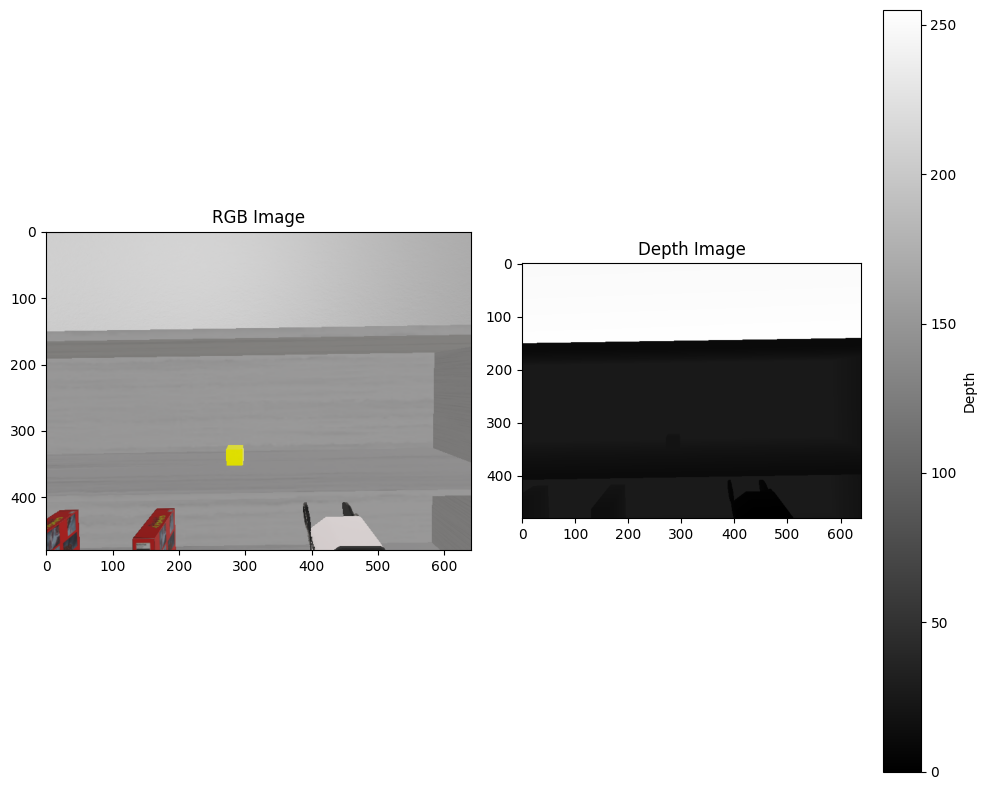

In [4]:
# Display the RGB image
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.title('RGB Image')
plt.axis('on')

# Display the depth image
plt.subplot(1, 2, 2)
# Normalize the depth data for visualization
depth_min = np.min(depth_image[np.isfinite(depth_image)])
depth_max = np.max(depth_image[np.isfinite(depth_image)])

# Create a mask for invalid values (NaN or inf)
invalid_mask = ~np.isfinite(depth_image)

# Create normalized array
normalized_depth = np.full_like(depth_image, 255, dtype=np.float32)
if depth_max > depth_min:
    # Only normalize valid values
    normalized_depth[~invalid_mask] = (depth_image[~invalid_mask] - depth_min) / (depth_max - depth_min) * 255
normalized_depth = normalized_depth.astype(np.uint8)

plt.imshow(normalized_depth, cmap='gray')
plt.colorbar(label='Depth')
plt.title('Depth Image')

plt.tight_layout()
plt.show()


In [5]:
depth_image.max()

inf

In [6]:
rgb_image.max()

237

In [7]:
# Parameters from the file
width = 640
height = 480
fov_x_rad = 1.49

# Calculate principal point
cx = width / 2
cy = height / 2

# Calculate focal length
fx = (width / 2) / np.tan(fov_x_rad / 2)
fy = fx # Assuming square pixels

# Construct the intrinsic matrix
intrinsic_matrix = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])
# Create a PinholeCameraIntrinsic object from the intrinsic matrix parameters
# intrinsic_matrix = np.array([
#     [616.486, 0, 322.608],
#     [0, 616.819, 239.962],
#     [0, 0, 1]
# ])

# Also create an Open3D intrinsic object for point cloud operations

o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=width,
    height=height,
    fx=intrinsic_matrix[0, 0],
    fy=intrinsic_matrix[1, 1],
    cx=intrinsic_matrix[0, 2],
    cy=intrinsic_matrix[1, 2]
)

# Test object detection with the created intrinsic matrix
# Note: This is a simplified test - real applications would need proper camera calibration
result_image, object_mask, detections = image_tools.process_and_extract_objects(rgb_image, depth_image, o3d_intrinsic)



0: 480x640 23 objects, 22.7ms
Speed: 1.0ms preprocess, 22.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


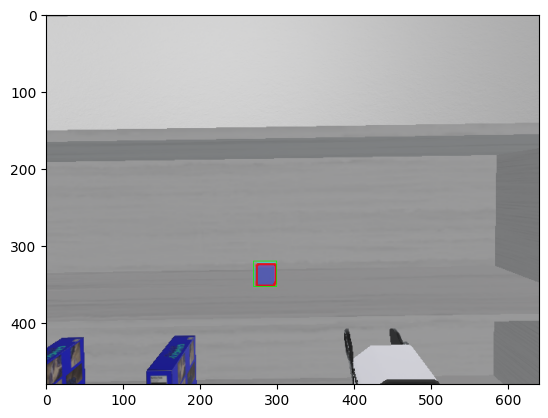

In [8]:
plt.imshow(result_image)

In [9]:
rows, cols = np.where(object_mask)
centroid = np.array([np.round(np.mean(cols)), np.round(np.mean(rows))], dtype=int)
print(f"Object centroid (x, y): {centroid}")

Object centroid (x, y): [285 338]


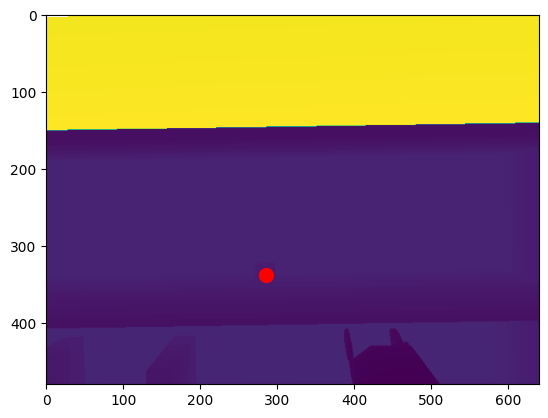

In [10]:
plt.imshow(depth_image)
plt.scatter(centroid[0], centroid[1], color='red', s=100)
plt.show()


In [32]:
depth_image[centroid[1],centroid[0]]

599.9999642372131